In [ ]:
!pip3 install gower


Predicted Clusters (Sorted by Cluster Number, distance <= 0.4)
ID  Predicted Cluster
 2                  1
 4                  1
11                  2
15                  2
 8                  2
 1                  2
 9                  2
12                  2
 3                  2
17                  2
 6                  2
 7                  3
19                  3
20                  4
 5                  4
18                  4
10                  4
13                  4
16                  4
14                  4

Number of clusters found at distance 0.4: 4

Cluster Sizes:
Predicted Cluster
1    2
2    9
3    2
4    7
Name: count, dtype: int64


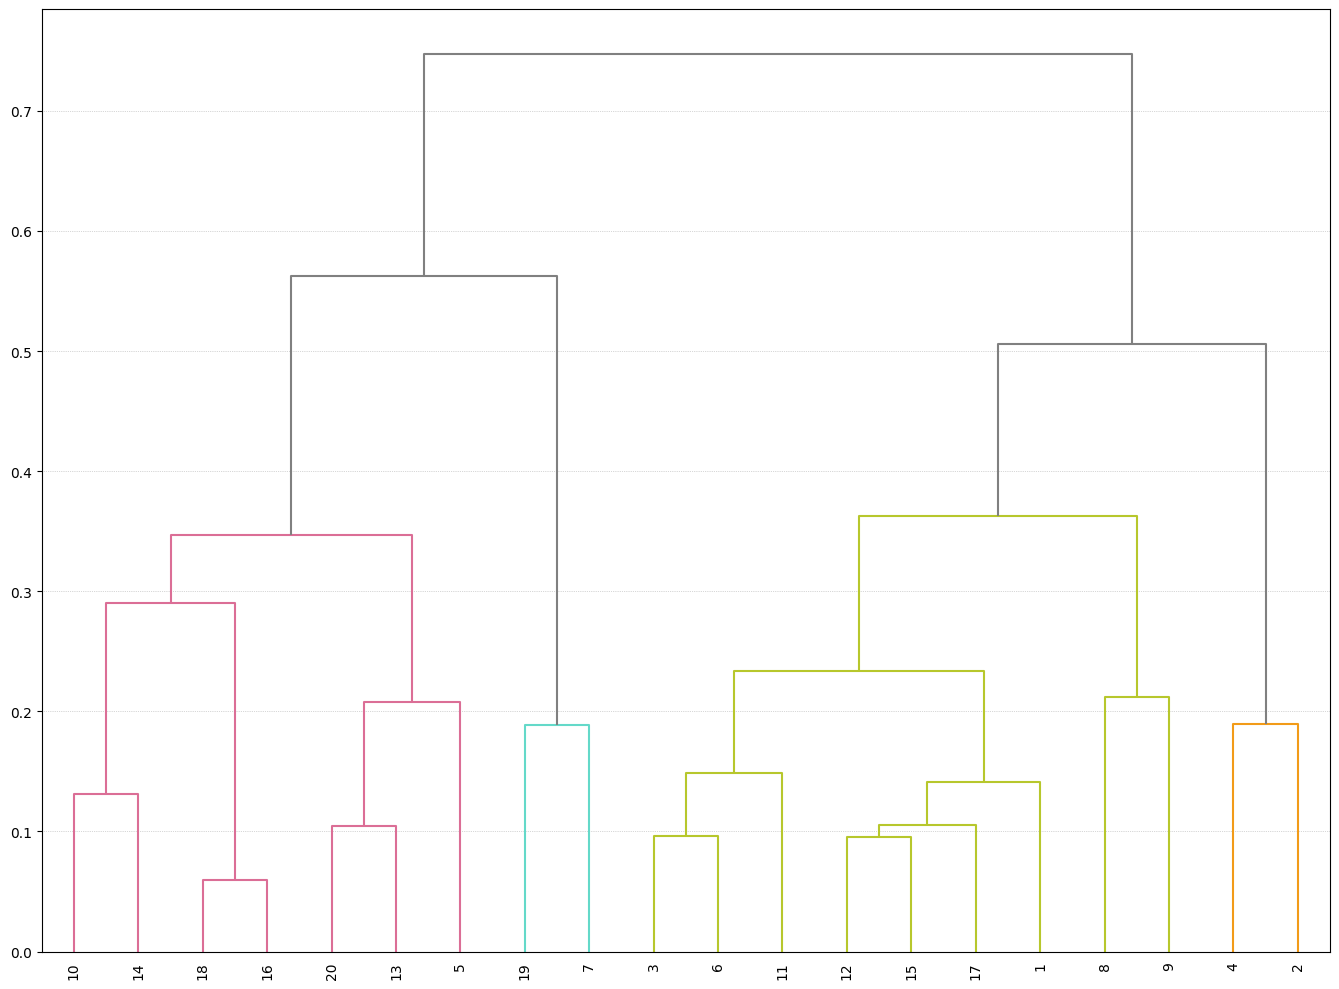

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform
import gower
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sys

data = [
    ['16', 124008407040, 38677401600, 'multipolar', 234517.2827, 0, 0, 1, 746, 414, 42],
    ['14', 155282350080, 45789296640, 'bipolar', 147096.206, 0, 0, 1, 977, 256, 100],
    ['13', 168469309440, 34900439040, 'multipolar', 383703.5945, 0, 0, 1, 2609, 585, 528],
    ['18', 130380072960, 40242923520, 'multipolar', 229978.5113, 0, 0, 1, 973, 746, 67],
    ['5', 173906227200, 33367234560, 'bipolar', 265659.514, 0, 0, 1, 2294, 650, 547],
    ['20', 208749496320, 39632885760, 'multipolar', 355348.8553, 0, 0, 1, 1848, 794, 158],
    ['2', 164527994880, 43507568640, 'bipolar', 120738.7693, 4, 1, 1, 1407, 200, 186],
    ['4', 107651973120, 35105617920, 'bipolar', 63075.63401, 4, 1, 1, 756, 140, 47],
    ['10', 128919244800, 46152130560, 'bipolar', 39082.73965, 0, 0, 1, 1592, 354, 172],
    ['7', 86131230720, 28778035200, 'unipolar', 57184.89032, 0, 0, 0, 935, 606, 11],
    ['19', 108731043840, 31402782720, 'unipolar', 66012.68547, 0, 1, 0, 1410, 500, 19],
    ['9', 138603847680, 37885255680, 'unipolar', 51708.15625, 19, 1, 0, 1035, 1490, 42],
    ['8', 99765473280, 33157632000, 'unipolar', 50367.52127, 10, 1, 0, 451, 316, 11],
    ['1', 130214338560, 37502853120, 'pseudounipolar', 68757.72662, 11, 1, 0, 1201, 439, 4],
    ['11', 175661045760, 51965767680, 'pseudounipolar', 52147.47713, 4, 1, 0, 794, 1298, 19],
    ['15', 110534277120, 31753912320, 'pseudounipolar', 71870.35016, 5, 1, 0, 1791, 911, 8],
    ['12', 108910295040, 36555909120, 'pseudounipolar', 73957.49723, 10, 1, 0, 1092, 943, 20],
    ['6', 145621862400, 37960642560, 'pseudounipolar', 78434.7676, 17, 1, 0, 808, 1548, 14],
    ['17', 122137896960, 41560104960, 'pseudounipolar', 44101.97098, 5, 1, 0, 1627, 842, 20],
    ['3', 164652687360, 41093191680, 'pseudounipolar', 62134.37108, 10, 1, 0, 652, 2156, 34]
]

cols = ['ID', 'TotalVol', 'NucVol', 'Branch', 'TotalLen', 'Mic', 'Cilia', 'Handshake', 'CV', 'DCV', 'DCVH']
df = pd.DataFrame(data, columns=cols)
n_samples = len(df)

num_cols = ['TotalVol', 'NucVol', 'TotalLen', 'Mic', 'Cilia', 'Handshake', 'CV', 'DCV', 'DCVH']
cat_cols = ['Branch']
features_for_clustering = num_cols + cat_cols

df_features = df[features_for_clustering].copy()

for col in ['TotalVol', 'NucVol', 'TotalLen', 'Mic', 'CV', 'DCV', 'DCVH']:
    if df_features[col].min() <= 0:
        df_features[col] = np.log(df_features[col] - df_features[col].min() + 1)
    else:
        df_features[col] = np.log(df_features[col])

df_features[cat_cols] = df_features[cat_cols].astype(object)
categorical_features_mask = [col in cat_cols for col in df_features.columns]

distance_matrix = gower.gower_matrix(df_features, cat_features=categorical_features_mask)
condensed_distance_matrix = squareform(distance_matrix)
linked = linkage(condensed_distance_matrix, method='complete')

distance_threshold = 0.4
clusters = fcluster(linked, t=distance_threshold, criterion='distance')
df['predicted_cluster'] = clusters

output_df = df[['ID', 'predicted_cluster']].rename(columns={'predicted_cluster': 'Predicted Cluster'})
output_df_sorted = output_df.sort_values(by='Predicted Cluster')
print(f"\nPredicted Clusters (Sorted by Cluster Number, distance <= {distance_threshold})")
print(output_df_sorted.to_string(index=False))
num_clusters_found = len(output_df_sorted['Predicted Cluster'].unique())
print(f"\nNumber of clusters found at distance {distance_threshold}: {num_clusters_found}")
print("\nCluster Sizes:")
print(output_df_sorted['Predicted Cluster'].value_counts().sort_index())

cluster_labels = sorted(output_df_sorted['Predicted Cluster'].unique())
hex_colors = ['#F29B18', '#B7C72C', '#64D9C9', '#DB6E96', '#A0A0A0']

color_map = {label: hex_colors[i % len(hex_colors)] for i, label in enumerate(cluster_labels)}
default_link_color = '#808080'

memo_leaf = {}

def get_one_leaf(node_id):
    if node_id in memo_leaf:
        return memo_leaf[node_id]
    if node_id < n_samples:
        memo_leaf[node_id] = node_id
        return node_id
    else:
        link_idx = int(node_id - n_samples)
        child1_id = int(linked[link_idx, 0])
        leaf_idx = get_one_leaf(child1_id)
        memo_leaf[node_id] = leaf_idx
        return leaf_idx

def get_link_color_simple(cluster_id):
    link_idx = int(cluster_id - n_samples)
    if link_idx < 0 or link_idx >= linked.shape[0]:
        return default_link_color
    merge_distance = linked[link_idx, 2]
    if merge_distance > distance_threshold:
        return default_link_color
    else:
        leaf_index = get_one_leaf(cluster_id)
        final_cluster_label = clusters[leaf_index]
        return color_map.get(final_cluster_label, default_link_color)

plt.figure(figsize=(15, 10))
memo_leaf.clear()

legend_handles = [mpatches.Patch(color=color_map[label], label=f'Type {label}') for label in cluster_labels if label in color_map]

dendrogram_result = dendrogram(
    linked,
    orientation='top',
    labels=df['ID'].values,
    distance_sort='descending',
    show_leaf_counts=True,
    link_color_func=lambda k: get_link_color_simple(k),
    above_threshold_color=default_link_color
)

plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle=':', linewidth=0.5)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

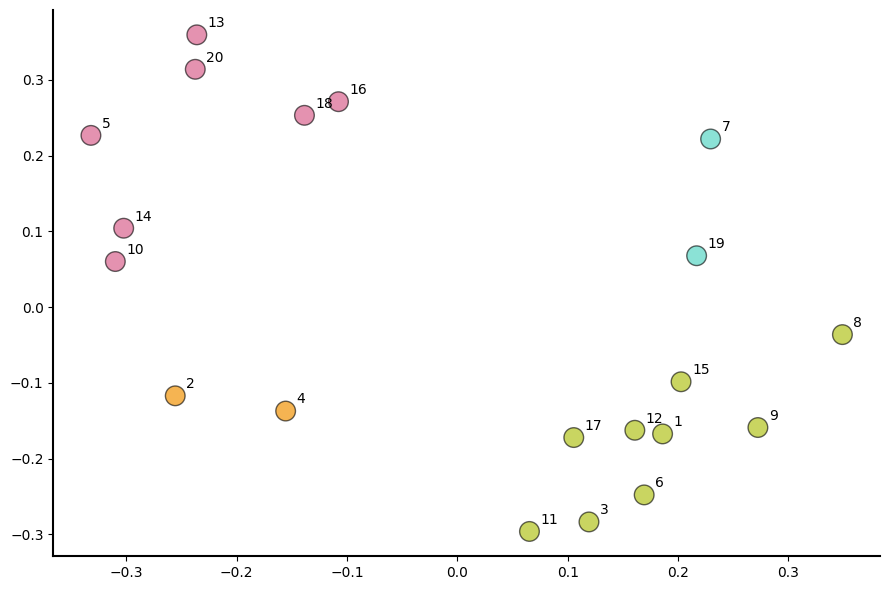

In [ ]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress=False)
mds_coords = mds.fit_transform(distance_matrix)
mds_df = pd.DataFrame(mds_coords, columns=['MDS1', 'MDS2'], index=df.index)
mds_df['predicted_cluster'] = df['predicted_cluster']
mds_df['ID'] = df['ID']
fig, ax = plt.subplots(figsize=(9, 6))

face_alpha = 0.75
edge_alpha = 0.6
edge_base_color = 'black'

cluster_colors_mapped = mds_df['predicted_cluster'].map(color_map).fillna(default_link_color)
face_colors_rgba = [mcolors.to_rgba(hex_color, alpha=face_alpha) for hex_color in cluster_colors_mapped]
edge_color_rgba = mcolors.to_rgba(edge_base_color, alpha=edge_alpha)

ax.scatter(mds_df['MDS1'], mds_df['MDS2'], c=face_colors_rgba, s=200, edgecolors=edge_color_rgba, linewidths=1)
ax.tick_params(axis='both', which='major', labelsize=10)

for i, txt in enumerate(mds_df['ID']):
  ax.text(mds_df['MDS1'].iloc[i] + 0.01, mds_df['MDS2'].iloc[i] + 0.01, txt, fontsize=10)

axis_thickness = 1.5
ax.spines['left'].set_linewidth(axis_thickness)
ax.spines['bottom'].set_linewidth(axis_thickness)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
plt.show()